# import

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import random
import gym

import tensorflow as tf

# Cofig

In [2]:
INPUT_DIM = 4
ACTION_DIM = 2

BATCH_SIZE = 64
DISCOUNT_FACTOR = 0.99

NUM_EPISODE = 1000
RENDER = False # Visualize but slow
REWARD_SUM_QUEUE_SIZE = 100

MEMORY_SIZE = 2000
TRAIN_START = 1000

# Replay memory

In [3]:
class ReplayMemory:
    def __init__(self, size):
        self.size = size

        self.states = np.empty((self.size, INPUT_DIM), dtype = np.float32)
        self.actions = np.empty((self.size), dtype = np.int16)
        self.rewards = np.empty((self.size), dtype = np.int16)
        self.next_states = np.empty((self.size, INPUT_DIM), dtype = np.float32)
        self.dones = np.empty((self.size), dtype = np.bool)

        self.count = 0
        self.current = 0

    def add(self, state, action, reward, next_state, done):
        self.states[self.current, ...] = state
        self.actions[self.current] =  action
        self.rewards[self.current] = reward
        self.next_states[self.current, ...] = next_state
        self.dones[self.current] = done 

        self.count = max(self.count, self.current + 1) 
        self.current = (self.current + 1) % self.size 

    def sample_batch(self, type='all'):
        shuffle_idx = np.arange(0, self.count)
        np.random.shuffle(shuffle_idx)
        shuffle_idx = shuffle_idx[:BATCH_SIZE]
        
        states = copy(self.states[shuffle_idx])
        actions = self.actions[shuffle_idx]
        rewards = self.rewards[shuffle_idx]
        next_states = copy(self.next_states[shuffle_idx])
        dones = self.dones[shuffle_idx]

        return states, actions, rewards, next_states, dones

# Network

In [4]:
class Network(object):
    def __init__(self, device):
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with tf.device(device):
                self.create_placeholder()
                self.create_network()
                self.create_train_op()
                self.sess = tf.Session(
                    graph=self.graph,
                    config=tf.ConfigProto(
                        allow_soft_placement=True,
                        log_device_placement=False,
                        gpu_options=tf.GPUOptions(allow_growth=True)))
                self.sess.run(tf.global_variables_initializer())

    def create_placeholder(self):
        self.state_t = tf.placeholder(tf.float32, [None, INPUT_DIM], name='state_t')
        self.action_t = tf.placeholder(tf.int32, [None], name="action_t")
        self.reward_tp1 = tf.placeholder(tf.float32, [None], name="reward_tp1")
        self.state_tp1 = tf.placeholder(tf.float32, [None, INPUT_DIM], name="state_tp1") 
        self.done = tf.placeholder(tf.bool, [None], name="done")

    def create_network(self):
        with tf.variable_scope("q_network"):
            fc_1 = tf.layers.dense(self.state_t, 10, activation=tf.nn.relu, name='fc_1')
            fc_2 = tf.layers.dense(fc_1, 10, activation=tf.nn.relu, name='fc_2')
            self.q = tf.layers.dense(fc_2, ACTION_DIM, activation=None, name='q')
        self.q_network_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='q_network')

        with tf.variable_scope("target_q_network"):
            fc_1 = tf.layers.dense(self.state_tp1, 10, activation=tf.nn.relu, name='fc_1')
            fc_2 = tf.layers.dense(fc_1, 10, activation=tf.nn.relu, name='fc_2')
            self.target_q = tf.layers.dense(fc_2, ACTION_DIM, activation=None, name='target_q')
        self.target_q_network_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_q_network')

        self.update_target_q_network_op = tf.group(
            *[tq.assign(q) for q, tq in zip(
                sorted(self.q_network_vars, key=lambda v: v.name),
                sorted(self.target_q_network_vars, key=lambda v: v.name))])

    def create_train_op(self):
        self.q_acted = tf.reduce_sum(self.q * tf.one_hot(self.action_t, ACTION_DIM), 1) # Q(S_{t}, A_{t})
        # if done -> true, target becomes zero
        self.target = self.reward_tp1 + DISCOUNT_FACTOR \
            * (1. - tf.cast(self.done, tf.float32)) * tf.reduce_max(self.target_q, 1)
        self.cost = tf.reduce_mean(tf.squared_difference(self.q_acted, tf.stop_gradient(self.target)))

        self.opt = tf.train.AdamOptimizer(learning_rate=0.01)
        self.train_op = self.opt.minimize(self.cost, var_list=self.q_network_vars)

    def update_target_q_network(self):
        self.sess.run(self.update_target_q_network_op)

    def predict_q_single(self, state_t):
        return self.sess.run([self.q], feed_dict={self.state_t: state_t[np.newaxis, :]})

    def train(self, state_t, action_t, reward_tp1, state_tp1, done):
        feed_dict = {
            self.state_t: state_t,
            self.action_t: action_t,
            self.reward_tp1: reward_tp1,
            self.state_tp1: state_tp1,
            self.done: done
        }
        self.sess.run(self.train_op, feed_dict=feed_dict)


# Agent

In [5]:
import numpy as np
import random

INPUT_DIM = 4
ACTION_DIM = 2

EPSILON_DECAY = 0.999 
EPSILON_MIN = 0.01

class Agent(object):
    def __init__(self, network):
        self.network = network
        self.epsilon = 1.0
        self.epsilon_decay = EPSILON_DECAY 
        self.epsilon_min = EPSILON_MIN 
       
    def train_network(self, states, actions, rewards, next_states, dones):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.network.train(states, actions, rewards, next_states, dones)

    def update_target_q_network(self):
        self.network.update_target_q_network()

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(ACTION_DIM)
        else:
            q = self.network.predict_q_single(state)
            return np.argmax(q)

# Train

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0, avg_score: 10.00, memory_count: 10, epsilon: 1.00
episode: 1, avg_score: 17.50, memory_count: 35, epsilon: 1.00
episode: 2, avg_score: 17.33, memory_count: 52, epsilon: 1.00
episode: 3, avg_score: 19.50, memory_count: 78, epsilon: 1.00
episode: 4, avg_score: 20.60, memory_count: 103, epsilon: 1.00
episode: 5, avg_score: 22.67, memory_count: 136, epsilon: 1.00
episode: 6, avg_score: 21.71, memory_count: 152, epsilon: 1.00
episode: 7, avg_score: 22.00, memory_count: 176, epsilon: 1.00
episode: 8, avg_score: 20.89, memory_count: 188, epsilon: 1.00
episode: 9, avg_score: 22.00, memory_count: 220, epsilon: 1.00
episode: 10, avg_score: 22.82, memory_count: 251, epsilon: 1.00
episode: 11, avg_score: 21.92, memory_count: 263, epsilon: 1.00
episode: 12, avg_score: 21.77, memory_count: 283, epsilon: 1.00
episode: 13, avg_score: 21.00, memory_count: 294, epsilon: 1.00
episode: 14, avg_sc

episode: 126, avg_score: 100.68, memory_count: 2000, epsilon: 0.01
episode: 127, avg_score: 102.26, memory_count: 2000, epsilon: 0.01
episode: 128, avg_score: 104.13, memory_count: 2000, epsilon: 0.01
episode: 129, avg_score: 105.17, memory_count: 2000, epsilon: 0.01
episode: 130, avg_score: 105.32, memory_count: 2000, epsilon: 0.01
episode: 131, avg_score: 106.26, memory_count: 2000, epsilon: 0.01
episode: 132, avg_score: 106.46, memory_count: 2000, epsilon: 0.01
episode: 133, avg_score: 107.68, memory_count: 2000, epsilon: 0.01
episode: 134, avg_score: 109.40, memory_count: 2000, epsilon: 0.01
episode: 135, avg_score: 110.28, memory_count: 2000, epsilon: 0.01
episode: 136, avg_score: 112.16, memory_count: 2000, epsilon: 0.01
episode: 137, avg_score: 113.98, memory_count: 2000, epsilon: 0.01
episode: 138, avg_score: 115.60, memory_count: 2000, epsilon: 0.01
episode: 139, avg_score: 117.46, memory_count: 2000, epsilon: 0.01
episode: 140, avg_score: 119.20, memory_count: 2000, epsilon: 

episode: 249, avg_score: 151.79, memory_count: 2000, epsilon: 0.01
episode: 250, avg_score: 152.80, memory_count: 2000, epsilon: 0.01
episode: 251, avg_score: 154.02, memory_count: 2000, epsilon: 0.01
episode: 252, avg_score: 155.06, memory_count: 2000, epsilon: 0.01
episode: 253, avg_score: 156.16, memory_count: 2000, epsilon: 0.01
episode: 254, avg_score: 157.22, memory_count: 2000, epsilon: 0.01
episode: 255, avg_score: 158.21, memory_count: 2000, epsilon: 0.01
episode: 256, avg_score: 159.76, memory_count: 2000, epsilon: 0.01
episode: 257, avg_score: 160.13, memory_count: 2000, epsilon: 0.01
episode: 258, avg_score: 160.95, memory_count: 2000, epsilon: 0.01
episode: 259, avg_score: 161.79, memory_count: 2000, epsilon: 0.01
episode: 260, avg_score: 161.87, memory_count: 2000, epsilon: 0.01
episode: 261, avg_score: 162.61, memory_count: 2000, epsilon: 0.01
episode: 262, avg_score: 163.47, memory_count: 2000, epsilon: 0.01
episode: 263, avg_score: 164.24, memory_count: 2000, epsilon: 

episode: 374, avg_score: 163.82, memory_count: 2000, epsilon: 0.01
episode: 375, avg_score: 162.28, memory_count: 2000, epsilon: 0.01
episode: 376, avg_score: 160.43, memory_count: 2000, epsilon: 0.01
episode: 377, avg_score: 159.42, memory_count: 2000, epsilon: 0.01
episode: 378, avg_score: 158.60, memory_count: 2000, epsilon: 0.01
episode: 379, avg_score: 158.17, memory_count: 2000, epsilon: 0.01
episode: 380, avg_score: 156.37, memory_count: 2000, epsilon: 0.01
episode: 381, avg_score: 156.08, memory_count: 2000, epsilon: 0.01
episode: 382, avg_score: 154.34, memory_count: 2000, epsilon: 0.01
episode: 383, avg_score: 152.47, memory_count: 2000, epsilon: 0.01
episode: 384, avg_score: 150.82, memory_count: 2000, epsilon: 0.01
episode: 385, avg_score: 149.66, memory_count: 2000, epsilon: 0.01
episode: 386, avg_score: 149.59, memory_count: 2000, epsilon: 0.01
episode: 387, avg_score: 149.62, memory_count: 2000, epsilon: 0.01
episode: 388, avg_score: 149.88, memory_count: 2000, epsilon: 

episode: 497, avg_score: 164.93, memory_count: 2000, epsilon: 0.01
episode: 498, avg_score: 164.30, memory_count: 2000, epsilon: 0.01
episode: 499, avg_score: 163.29, memory_count: 2000, epsilon: 0.01
episode: 500, avg_score: 164.03, memory_count: 2000, epsilon: 0.01
episode: 501, avg_score: 164.69, memory_count: 2000, epsilon: 0.01
episode: 502, avg_score: 165.34, memory_count: 2000, epsilon: 0.01
episode: 503, avg_score: 166.03, memory_count: 2000, epsilon: 0.01
episode: 504, avg_score: 166.46, memory_count: 2000, epsilon: 0.01
episode: 505, avg_score: 165.67, memory_count: 2000, epsilon: 0.01
episode: 506, avg_score: 165.23, memory_count: 2000, epsilon: 0.01
episode: 507, avg_score: 165.03, memory_count: 2000, epsilon: 0.01
episode: 508, avg_score: 165.53, memory_count: 2000, epsilon: 0.01
episode: 509, avg_score: 164.80, memory_count: 2000, epsilon: 0.01
episode: 510, avg_score: 165.29, memory_count: 2000, epsilon: 0.01
episode: 511, avg_score: 165.84, memory_count: 2000, epsilon: 

episode: 620, avg_score: 155.99, memory_count: 2000, epsilon: 0.01
episode: 621, avg_score: 155.34, memory_count: 2000, epsilon: 0.01
episode: 622, avg_score: 154.08, memory_count: 2000, epsilon: 0.01
episode: 623, avg_score: 152.81, memory_count: 2000, epsilon: 0.01
episode: 624, avg_score: 151.57, memory_count: 2000, epsilon: 0.01
episode: 625, avg_score: 150.24, memory_count: 2000, epsilon: 0.01
episode: 626, avg_score: 149.62, memory_count: 2000, epsilon: 0.01
episode: 627, avg_score: 149.24, memory_count: 2000, epsilon: 0.01
episode: 628, avg_score: 149.03, memory_count: 2000, epsilon: 0.01
episode: 629, avg_score: 148.65, memory_count: 2000, epsilon: 0.01
episode: 630, avg_score: 148.42, memory_count: 2000, epsilon: 0.01
episode: 631, avg_score: 149.50, memory_count: 2000, epsilon: 0.01
episode: 632, avg_score: 149.74, memory_count: 2000, epsilon: 0.01
episode: 633, avg_score: 150.99, memory_count: 2000, epsilon: 0.01
episode: 634, avg_score: 152.16, memory_count: 2000, epsilon: 

episode: 743, avg_score: 177.32, memory_count: 2000, epsilon: 0.01
episode: 744, avg_score: 177.42, memory_count: 2000, epsilon: 0.01
episode: 745, avg_score: 176.33, memory_count: 2000, epsilon: 0.01
episode: 746, avg_score: 175.48, memory_count: 2000, epsilon: 0.01
episode: 747, avg_score: 175.13, memory_count: 2000, epsilon: 0.01
episode: 748, avg_score: 175.07, memory_count: 2000, epsilon: 0.01
episode: 749, avg_score: 175.62, memory_count: 2000, epsilon: 0.01
episode: 750, avg_score: 175.30, memory_count: 2000, epsilon: 0.01
episode: 751, avg_score: 175.30, memory_count: 2000, epsilon: 0.01
episode: 752, avg_score: 175.30, memory_count: 2000, epsilon: 0.01
episode: 753, avg_score: 175.49, memory_count: 2000, epsilon: 0.01
episode: 754, avg_score: 175.81, memory_count: 2000, epsilon: 0.01
episode: 755, avg_score: 176.01, memory_count: 2000, epsilon: 0.01
episode: 756, avg_score: 176.23, memory_count: 2000, epsilon: 0.01
episode: 757, avg_score: 176.37, memory_count: 2000, epsilon: 

episode: 866, avg_score: 150.54, memory_count: 2000, epsilon: 0.01
episode: 867, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 868, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 869, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 870, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 871, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 872, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 873, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 874, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 875, avg_score: 151.51, memory_count: 2000, epsilon: 0.01
episode: 876, avg_score: 152.76, memory_count: 2000, epsilon: 0.01
episode: 877, avg_score: 152.76, memory_count: 2000, epsilon: 0.01
episode: 878, avg_score: 152.83, memory_count: 2000, epsilon: 0.01
episode: 879, avg_score: 152.83, memory_count: 2000, epsilon: 0.01
episode: 880, avg_score: 152.83, memory_count: 2000, epsilon: 

episode: 989, avg_score: 163.47, memory_count: 2000, epsilon: 0.01
episode: 990, avg_score: 162.71, memory_count: 2000, epsilon: 0.01
episode: 991, avg_score: 162.81, memory_count: 2000, epsilon: 0.01
episode: 992, avg_score: 162.77, memory_count: 2000, epsilon: 0.01
episode: 993, avg_score: 162.80, memory_count: 2000, epsilon: 0.01
episode: 994, avg_score: 161.79, memory_count: 2000, epsilon: 0.01
episode: 995, avg_score: 160.97, memory_count: 2000, epsilon: 0.01
episode: 996, avg_score: 160.97, memory_count: 2000, epsilon: 0.01
episode: 997, avg_score: 160.97, memory_count: 2000, epsilon: 0.01
episode: 998, avg_score: 160.97, memory_count: 2000, epsilon: 0.01
episode: 999, avg_score: 160.97, memory_count: 2000, epsilon: 0.01


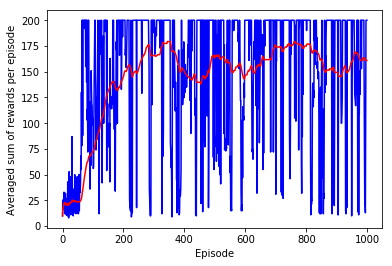

In [6]:
env = gym.make('CartPole-v0')
network = Network("cpu:0")
agent = Agent(network)
replay_memory = ReplayMemory(MEMORY_SIZE)

reward_sum_queue = []
reward_sum_history = []
reward_sum_avg_history = []
for n_episode in range(NUM_EPISODE):
    state = env.reset()

    done = False 
    reward_sum = 0.0
    while not done:
        if RENDER:
            env.render()

        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward 

        replay_memory.add(state, action, reward, next_state, done)

        if replay_memory.count > TRAIN_START:
            agent.train_network(*replay_memory.sample_batch())

        state = next_state # change current state

        if done:
            if len(reward_sum_queue) > REWARD_SUM_QUEUE_SIZE:
                reward_sum_queue.append(reward_sum)
                reward_sum_queue.pop(0)
            else:
                reward_sum_queue.append(reward_sum)
            reward_sum_history.append(reward_sum)
            reward_sum_avg_history.append(np.mean(reward_sum_queue))

            agent.update_target_q_network()
            print("episode: %d, avg_score: %.2f, memory_count: %d, epsilon: %.2f" 
                % (n_episode, np.mean(reward_sum_queue), replay_memory.count, agent.epsilon))

plt.plot(reward_sum_history, 'b')
plt.plot(reward_sum_avg_history, 'r')
plt.xlabel('Episode')
plt.ylabel('Averaged sum of rewards per episode')
plt.show()